# Projeto Spark

A ser realizado em duplas.

Alunos: Lívia Sayuri Makuta e Bernardo Cunha Capoferri.

Entrega: 6 de dezembro de 2022

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v `pwd`:/home/jovyan/work \
    jupyter/pyspark-notebook


```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [4]:
#rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [3]:
rdd = sc.pickleFile('reviews.pickle')

In [6]:
rdd.count()

3600000

In [7]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [14]:
def separa_em_palavras(item):
    titulo = item[1]
    corpo = item[2]
    return titulo.split() + corpo.split()

In [15]:
def conta_palavras_rdd(rdd):
    operacao =  rdd \
                .flatMap(separa_em_palavras) \
                .map(lambda x: (x, 1)) \
                .reduceByKey(lambda x, y : x+y) 
    return operacao

In [16]:
contagem = conta_palavras_rdd(rdd)

In [17]:
contagem.take(10)

[('destroyed', 4609),
 ('book', 1398748),
 ('out', 667825),
 ('Crucible', 79),
 ('incredible.READ', 1),
 ('like', 930710),
 ('Puritan', 127),
 ('way.', 30976),
 ('line,', 7172),
 ('teaching', 11832)]

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [18]:
import numpy as np

In [19]:
# contagem.map(lambda x: x[1]).reduce(lambda x, y: x + y)

In [20]:
T = contagem.reduce(lambda x, y: ("tudo", x[1]+y[1]))

In [21]:
T

('tudo', 282485435)

In [22]:
v = 1e6
def calcula_log(rdd, T):
    operacao = rdd \
                .map(lambda x: (x[0], np.log10(x[1]/T[1])))    
                #.map(lambda x: (x[0], np.log10(x[1] + alfa/T[1] + alfa*v)))     

    return operacao

In [23]:
resultado = calcula_log(contagem, T).take(10)

In [24]:
resultado

[('destroyed', -4.787389352306342),
 ('book', -2.3052565818700304),
 ('out', -2.6263333876130455),
 ('Crucible', -6.553368969140421),
 ('incredible.READ', -8.450996060430862),
 ('like', -2.4821816802222187),
 ('Puritan', -6.347192339474906),
 ('way.', -3.9599707248025626),
 ('line,', -4.595355779540717),
 ('teaching', -4.377937899442026)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [25]:
def separa_sentimento(rdd):
    rdd_negativo = rdd\
                   .filter(lambda x: x[0] == 1)
    rdd_positivo = rdd\
                    .filter(lambda x: x[0] == 2)
    
    return rdd_positivo, rdd_negativo

In [26]:
rdd_positivo, rdd_negativo = separa_sentimento(rdd)

In [27]:
rdd_positivo.take(5)

[(2,
  'Unhumorful comedy?',
  'Why exactly is this novel considered a hilarious look at witchcraft?!? This book had absolutely NO humor in it. It was fairly good, but I still think they should take the comedy part out of it!'),
 (2,
  'ONE OF THE BEST PLAYS OUT THERE!!!!!!',
  "The Crucible is one of the most powerful plays I've ever read . I'm only 14, but that still says a lot. Right from the beginning , I was addicted and couldn't get away from it. Arthur Miller is incredible.READ THIS & you will thank me!!!"),
 (2,
  "it's great.",
  "I have finished reading the Crucible - it is simply great. The text is wonderful, full of ironies and dramatic scenes - for example, the scene where Elizabeth lies for the first time in her life to save Proctor's reputation, only to realise that her good intentions have unwittingly helped Abigail. Land wars, revenge and a host of other reasons show us the repressed state Salem was in in those days. The relationships between the main characters : Proc

In [28]:
rdd_negativo.take(5)

[(1,
  'Terrible',
  "I don't think i have hated many books more than this one. The writing, syntax, diction and those aspects were okay, but the stupidity of the characters was so frustrating that I destroyed the book and returned it to my English teacher in pieces. I don't recommend this book."),
 (1,
  'no thanks',
  'I never received this product. I was told it was mine and that it was shipped. Then I was told it was not mine and then it never came. I had to purchase the book somewhere else. So I am probably not going to order anything from amazon again. Time will tell'),
 (1,
  'School...',
  'I was forced to read this for school. So I did not enjoy it as much but it was a well written play and if you like to read Puritan English this is a good one to read.'),
 (1,
  'shipping time is somewhat long',
  'shipping time is longer than other book seller. i received the books after 3 weeks i ordered. Typically i receive books from other seller in a week.'),
 (1,
  'The Crucible',
  'Th

In [29]:
contagem_positivos = conta_palavras_rdd(rdd_positivo)
contagem_positivos.take(10)

[('book', 724631),
 ('out', 295965),
 ('Crucible', 52),
 ('incredible.READ', 1),
 ('like', 436043),
 ('teaching', 7376),
 ('way.', 16416),
 ('Witty,', 212),
 ('non-literal', 5),
 ('$70.96.maybe', 1)]

In [30]:
contagem_negativos = conta_palavras_rdd(rdd_negativo)
contagem_negativos.take(10)

[('destroyed', 3308),
 ('book', 674117),
 ('like', 494667),
 ('Puritan', 47),
 ('Crucible', 27),
 ('way.', 14560),
 ('line,', 4358),
 ('out', 371860),
 ('Act....', 1),
 ('crazy!', 354)]

In [31]:
T_positivo = contagem_positivos.reduce(lambda x, y: ("tudo_positivo", x[1]+y[1]))
T_negativo = contagem_negativos.reduce(lambda x, y: ("tudo_negativo", x[1]+y[1]))

In [32]:
T_positivo

('tudo_positivo', 135794961)

In [33]:
T_negativo

('tudo_negativo', 146690474)

In [34]:
resultado_positivo = calcula_log(contagem_positivos, T_positivo)
resultado_positivo.take(10)

[('book', -2.272766745312638),
 ('out', -2.6616432990632193),
 ('Crucible', -6.41688031106302),
 ('incredible.READ', -8.13288365469782),
 ('like', -2.493354335745979),
 ('teaching', -4.265062746652246),
 ('way.', -3.917616311266097),
 ('Witty,', -5.8065477937690675),
 ('non-literal', -7.4339136503618),
 ('$70.96.maybe', -8.13288365469782)]

In [35]:
resultado_negativo = calcula_log(contagem_negativos, T_negativo)
resultado_negativo.take(10)

[('destroyed', -4.646836411029836),
 ('book', -2.3376666325195163),
 ('like', -2.4720889730358304),
 ('Puritan', -6.494304053974628),
 ('Crucible', -6.735038147751358),
 ('way.', -4.003240536933327),
 ('line,', -4.527114686000108),
 ('out', -2.596022446951644),
 ('Act....', -8.166401911910345),
 ('crazy!', -5.617398649884557)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [36]:
tudo_junto = resultado_positivo\
                .fullOuterJoin(resultado_negativo)\
                .collect()

In [37]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di
      
dictionary_tudo_junto = {}
Convert(tudo_junto, dictionary_tudo_junto)
print("convertido!")

convertido!


In [38]:
#tudo_junto = {k: v for k, v in tudo_junto.items()}

In [39]:
tudo_junto[0]

('out', (-2.6616432990632193, -2.596022446951644))

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [40]:
comment1 = "I loved this product, it's the best I've ever had! After searching for so long I finally found and it's now my favorite. Thank you very much"
comment2 = "Worst place ever. I recommend any where else. Nothing but problems with them."

all_words1 = comment1.split()
all_words2 = comment2.split()

training = dictionary_tudo_junto

def Naive_Bayes(all_words, training):
    positivo = 0
    negativo = 0
    for word in all_words:
        if word in training:
            if training[word][0][0] != None:
                positivo += training[word][0][0]
            if training[word][0][1] != None:
                negativo += training[word][0][1]

    if positivo > negativo:
        print("É positivo")
        print("Essa é a probabilidade: ", positivo)
        return 2
    else:
        print("É negativo")
        print("Essa é a probabilidade: ", negativo)
        return 1
    

Naive_Bayes(all_words1, training)
Naive_Bayes(all_words2, training)
#all_words

É positivo
Essa é a probabilidade:  -79.18399616881938
É negativo
Essa é a probabilidade:  -42.356676592607116


1

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [41]:
tudo_junto_rdd = resultado_positivo\
                .fullOuterJoin(resultado_negativo)

In [42]:
def substitui_none(item):
    if item == None:
        item = 0
    return item

it = None

substitui_none(it)

0

In [43]:
#.map(lambda x:(x[0], abs(substitui_none(x[1][0])) - abs(substitui_none(x[1][1])))) \
# positivas - negativas. Maior diferença em módulo?

palavras_mais_positivas = tudo_junto_rdd \
                            .filter(lambda x: x[1][0] != None)\
                            .filter(lambda x: x[1][1] != None)\
                            .map(lambda x:(x[0], (x[1][0]) - (x[1][1])))\
                            .takeOrdered(100, lambda x: -x[1])
palavras_mais_positivas

[('Excellent!!!', 2.4226843415770585),
 ('must-read!', 2.2430332717551567),
 ('Inspiring!', 2.226642855566988),
 ('Outstanding!', 2.220333381659981),
 ('Excellent!!', 2.1827373698679065),
 ('Adorable!', 2.173397343613763),
 ('Underrated', 2.1491287688868264),
 ('Bookwatch', 2.1407282268603938),
 ('Fantastic!!', 2.137321978168483),
 ('Excellent!', 2.0897600634096705),
 ('Gem!', 2.086596700695946),
 ('must-have!', 2.080793124596706),
 ('Insightful!', 2.0749109423707512),
 ('Awesome!!!', 1.987760766651851),
 ('Excelente', 1.9845317965216527),
 ('MUST!', 1.9829082638574391),
 ('FANTASTIC!!!', 1.9780009293626941),
 ('Pleasantly', 1.973750052209037),
 ('Beautiful!', 1.9658470395875813),
 ('Superb!', 1.95650307292141),
 ('Captivating!', 1.9473321095962426),
 ('Mesmerizing', 1.9366082442044705),
 ('Impressive!', 1.9311453485029677),
 ('Eye-opening', 1.9256128599030067),
 ('Inspirational!', 1.9256128599030067),
 ('Underappreciated', 1.908579520604226),
 ('Addictive!', 1.9027499769435021),
 ('Mu

In [37]:
#.map(lambda x:(x[0], abs(substitui_none(x[1][1])) - abs(substitui_none(x[1][0])))) \

palavras_mais_negativas = tudo_junto_rdd \
                            .filter(lambda x: x[1][0] != None)\
                            .filter(lambda x: x[1][1] != None)\
                            .map(lambda x:(x[0], (x[1][1]) - (x[1][0]))) \
                            .takeOrdered(100, lambda x: -x[1])
palavras_mais_negativas

[('Worthless', 2.7038334385911877),
 ('Awful!', 2.63719133801127),
 ('Terrible!', 2.5171176927583643),
 ('Uninspired', 2.5055578415802504),
 ('Avoid!', 2.4941116436588127),
 ('Useless.', 2.491526549824319),
 ('Disappointed...', 2.491526549824319),
 ('JUNK!!!', 2.455032459287918),
 ('Junk!', 2.442636824735115),
 ('worthless!', 2.430374731773381),
 ('Worthless.', 2.4105265387055494),
 ('unfunny,', 2.404232305607861),
 ('Dull,', 2.390546268204961),
 ('Unreliable', 2.3502971087679043),
 ('JUNK!', 2.3466929844990796),
 ('Horrible.', 2.3181814431927394),
 ('Disappointing...', 2.3079162673656137),
 ('Horrible!', 2.3065952184933094),
 ('Tripe', 2.2782356038432283),
 ('Disappointment!', 2.259844297498919),
 ('Yawn', 2.2467565168608354),
 ('Boring,', 2.24440336171976),
 ('GARBAGE!', 2.2277446115799666),
 ('Atrocious', 2.2119944106016236),
 ('Unsatisfactory', 2.202010189695023),
 ('Disappointing.', 2.2011677171090014),
 ('Misrepresentation', 2.194368447401147),
 ('USELESS.', 2.186589830827529),
 

In [40]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 5.3 MB/s eta 0:00:00a 0:00:01


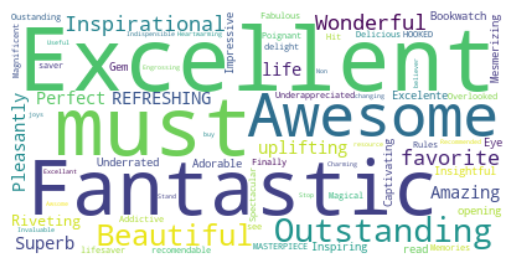

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_positivo = " ".join(word[0] for word in palavras_mais_positivas)
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text_positivo)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

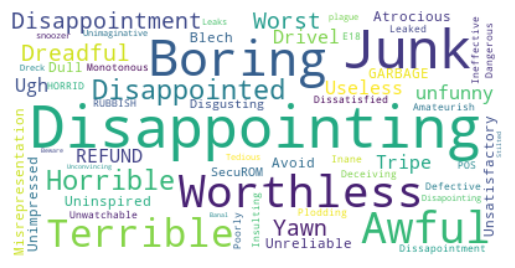

In [42]:
text_negativo = " ".join(word[0] for word in palavras_mais_negativas)
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text_negativo)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [5]:
#from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
#from pyspark.mllib.util import MLUtils

training, test = rdd.randomSplit(weights=[85, 15], seed=42)



In [6]:
training.take(5)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'),
 (2,
  'The best soundtrack ever to anything.',
  "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."),
 (2,
  'Amazing!',
  'This soundt

In [38]:
training.count()

3059625

In [8]:
def separa_em_palavras(item):
    titulo = item[1]
    corpo = item[2]
    return titulo.split() + corpo.split()

In [9]:
def conta_palavras_rdd(rdd):
    operacao =  rdd \
                .flatMap(separa_em_palavras) \
                .map(lambda x: (x, 1)) \
                .reduceByKey(lambda x, y : x+y) 
    return operacao

In [10]:
import numpy as np

v = 171476  #estimativa de quantas palavras existem em inglês
alfa = 1
def calcula_log_la_place_smoothing(rdd, T, v, alfa):
    operacao = rdd \
                .map(lambda x: (x[0], np.log10((x[1] + alfa)/(T[1] + alfa*v))))     

    return operacao

In [11]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di
      


In [12]:
def train(rdd):
    rdd_negativo = rdd\
                   .filter(lambda x: x[0] == 1)
    rdd_positivo = rdd\
                    .filter(lambda x: x[0] == 2)
    
    contagem_training_positivos = conta_palavras_rdd(rdd_negativo)
    contagem_training_negativos = conta_palavras_rdd(rdd_positivo)

    T_training_positivo = contagem_training_positivos.reduce(lambda x, y: ("tudo_positivo", x[1]+y[1]))
    T_training_negativo = contagem_training_negativos.reduce(lambda x, y: ("tudo_negativo", x[1]+y[1]))

    print("Total positivo do training: ", T_training_positivo)
    print("Total negativo do training: ", T_training_negativo)
    
    resultado_positivo_smoothing_training = calcula_log_la_place_smoothing(contagem_training_positivos, T_training_positivo, v, alfa)
    resultado_negativo_smoothing_training = calcula_log_la_place_smoothing(contagem_training_negativos, T_training_negativo, v, alfa)

    tudo_junto_smoothing_training = resultado_positivo_smoothing_training\
                .fullOuterJoin(resultado_negativo_smoothing_training)\
                .collectAsMap()
    return tudo_junto_smoothing_training

In [13]:
tudo_junto_smoothing_training = train(training)
#dictionary_tudo_junto_smoothing_training = {}
dictionary_tudo_junto_smoothing_training = tudo_junto_smoothing_training
#Convert(tudo_junto_smoothing_training, dictionary_tudo_junto_smoothing_training)
#print("convertido!")

Total positivo do training:  ('tudo_positivo', 124643855)
Total negativo do training:  ('tudo_negativo', 115477625)


In [14]:
tudo_junto_smoothing_training["Awesume"]

(-7.795237937116524, -7.762112265461189)

In [16]:
#training = dictionary_tudo_junto_smoothing_training
def Naive_Bayes_smoothing(all_words, training_b, Vb):
    training = training_b.value
    V = Vb.value
    positivo = 0
    negativo = 0
    for word in all_words:
        if word in training:
            if training[word][0] != None:
                positivo += training[word][0]
            else:
                positivo += np.log10(1.0/V)
            if training[word][1] != None:
                negativo += training[word][1]
            else:
                negativo += np.log10(1.0/V)

    if positivo > negativo:
        return 2
    else:
        return 1

In [17]:
training_b = sc.broadcast(dictionary_tudo_junto_smoothing_training)
vb = sc.broadcast(v)

In [18]:
from functools import partial

Naive_Bayes_with_backpack = partial(Naive_Bayes_smoothing, training_b=training_b, Vb=vb)


#all_words_training.take(1)
resultado_final = test\
                    .map(lambda x: (x[0], separa_em_palavras(x)))\
                    .map(lambda x: (Naive_Bayes_with_backpack(all_words = x[1]), x[0]))
            
#.map(lambda x: (x[0], join_strings(x))) \
#.map(freeze_Naive_Bayes)    
#Naive_Bayes_with_backpack
#map com reduce e subtrair para obter a acuracia
resultado_final.take(3)

[(2, 1), (2, 2), (2, 2)]

In [19]:
correct_predictions = resultado_final\
                            .filter(lambda tup: tup[0] == tup[1]) 

In [20]:
correct_predictions.take(10)

[(2, 2),
 (2, 2),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1)]

In [30]:
metade1, metade2 = correct_predictions.randomSplit(weights=[10, 90], seed=42)

In [31]:
acertos = sc.broadcast(metade1.collect())

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 16.0 failed 1 times, most recent failure: Lost task 5.0 in stage 16.0 (TID 437) (3e47d23696e5 executor driver): java.net.SocketException: Broken pipe
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:420)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:440)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:826)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:732)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Broken pipe
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:420)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:440)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:826)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:732)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)


In [27]:
acertos_metade = metade1.count()
acertos_metade

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 14.0 failed 1 times, most recent failure: Lost task 4.0 in stage 14.0 (TID 418) (3e47d23696e5 executor driver): java.net.SocketException: Broken pipe
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:420)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:440)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:826)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:732)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Broken pipe
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:420)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:440)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:826)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:732)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)


In [31]:
total_acertos = 42761*2

In [18]:
predicoes_certas = correct_predictions.count()
predicoes_certas

TypeError: object of type 'PipelinedRDD' has no len()

In [29]:
#final_results = correct_predictions.collect()

In [30]:
#final_results = sc.broadcast(correct_predictions.collect())

In [33]:
#lista_final = final_results.value

In [34]:
#predicoes_corretas = len(lista_final)
print(f"Esse é o número total de predições corretas {total_acertos}")

Esse é o número total de predições corretas 85522


In [35]:
numero_total_previsoes = test.count()
print(f"Esse é o número total de predições corretas {numero_total_previsoes}")

Esse é o número total de predições corretas 540375


In [31]:
acuracia = predicoes_corretas/numero_total_previsoes
print(f"Essa é a acurácia final: {acuracia}")

Essa é a acurácia final: 0.17196879251464586


In [32]:
#dicionario_final = correct_predictions.collectAsMap() # a gambiarra para tentar contar acertos

In [33]:
#correct_predictions = resultado_final\
#                            .filter(lambda tup: tup[0] == tup[1]) \
#                            .count()
#correct_predictions

In [ ]:
def calcula_acuracia(rdd_final, n_total):
    contabiliza = rdd_final\
                    .map(lambda x: conta_acertos(x[0], x[1]))
    
    soma_acertos = contabiliza\
                    .reduce(lambda x, y: x+y)
    
    #acuracia = soma_acertos/n_total
    
    #print(f"Essa é a acurácia calculada: {acuracia}")
    
    return soma_acertos

acertos = calcula_acuracia(resultado_final, numero_total_previsoes)

acertos

### Tarefa desafio!

Implemente Laplace smoothing

In [157]:
v = 171476  #estimativa de quantas palavras existem em inglês
alfa = 1
def calcula_log_la_place_smoothing(rdd, T, v, alfa):
    operacao = rdd \
                .map(lambda x: (x[0], np.log10((x[1] + alfa)/(T[1] + alfa*v))))     

    return operacao

In [158]:
resultado_smoothing = calcula_log_la_place_smoothing(contagem, T, v, alfa).take(10)
resultado_smoothing

[('out', -2.626596285356093),
 ('like', -2.4824447616497642),
 ('heart-rendering', -7.12904031375131),
 ('family', -3.654685275274799),
 ('book', -2.3055198194364985),
 ('let', -3.5857825260521867),
 ('angery.', -7.673108358101585),
 ('purposes.', -5.2404062431703355),
 ('wasting', -4.519750886618612),
 ('When', -3.3732815757177983)]

In [170]:
resultado_positivo_smoothing = calcula_log_la_place_smoothing(contagem_positivos, T_positivo, v, alfa)
resultado_positivo_smoothing.take(5)

[('out', -2.662189893996134),
 ('like', -2.4939014020721197),
 ('heart-rendering', -6.854678116060022),
 ('book', -2.2733142082961724),
 ('let', -3.659536191431884)]

In [171]:
resultado_negativo_smoothing = calcula_log_la_place_smoothing(contagem_negativos, T_negativo, v, alfa)
resultado_negativo_smoothing.take(5)

[('family', -3.9208294491509394),
 ('book', -2.3381733667423585),
 ('purposes.', -5.277047569116518),
 ('wasting', -4.287354689435731),
 ('item', -3.36960019225178)]

In [161]:
tudo_junto_smoothing = resultado_positivo_smoothing\
                .fullOuterJoin(resultado_negativo_smoothing)\
                .collect()

In [169]:
dictionary_tudo_junto_smoothing = {}
Convert(tudo_junto_smoothing, dictionary_tudo_junto_smoothing)
print("convertido!")

convertido!


In [163]:
comment1 = "I loved this product, it's the best I've ever had! After searching for so long I finally found and it's now my favorite. Thank you very much"
comment2 = "Worst place ever. I recommend any where else. Nothing but problems with them."

all_words1 = comment1.split()
all_words2 = comment2.split()

training = dictionary_tudo_junto_smoothing

def Naive_Bayes_smoothing(all_words, training, V):
    positivo = 0
    negativo = 0
    for word in all_words:
        if word in training:
            if training[word][0][0] != None:
                positivo += training[word][0][0]
            else:
                positivo += np.log10(1.0/V)
            if training[word][0][1] != None:
                negativo += training[word][0][1]
            else
                negativo += np.log10(1.0/V)

    if positivo > negativo:
        print("É positivo")
        print("Essa é a probabilidade: ", positivo)
        return 2
    else:
        print("É negativo")
        print("Essa é a probabilidade: ", negativo)
        return 1


Naive_Bayes_smoothing(all_words1, training, v)
Naive_Bayes_smoothing(all_words2, training, v)
#all_words

É positivo
Essa é a probabilidade:  -79.19724044492801
É negativo
Essa é a probabilidade:  -42.3630751654196


1

In [164]:
tudo_junto_rdd_smoothing = resultado_positivo_smoothing\
                .fullOuterJoin(resultado_negativo_smoothing)

In [189]:
# .map(lambda x:(x[0], abs(substitui_none(x[1][0])) - abs(substitui_none(x[1][1])))) \

palavras_mais_positivas_smoothing = tudo_junto_rdd_smoothing \
                            .filter(lambda x: x[1][0] != None)\
                            .filter(lambda x: x[1][1] != None)\
                            .map(lambda x:(x[0], substitui_none(x[1][0]) - (substitui_none(x[1][1])))) \
                            .takeOrdered(100, lambda x: -x[1])
palavras_mais_positivas_smoothing

[('Outstanding!', 2.1240882811902617),
 ('Excellent!!!', 2.1233826848012534),
 ('Excellent!', 2.071401830075481),
 ('Underrated', 2.0530092578931107),
 ('Excellent!!', 2.0081427541664834),
 ('must-read!', 1.9446351821018322),
 ('Inspiring!', 1.928347230107108),
 ('Excelente', 1.9183538190471543),
 ('Pleasantly', 1.9164287966124656),
 ('Beautiful!', 1.9085388367535554),
 ('must-have!', 1.906604336976356),
 ('Awesome!!!', 1.8920147709314943),
 ('Adorable!', 1.875462377951969),
 ('Superb!', 1.8608468464156802),
 ('Bookwatch', 1.8430372879971229),
 ('Fantastic!!', 1.8396575473457428),
 ('Fabulous!', 1.82499278530348),
 ('Wonderful!', 1.8111114985123171),
 ('MUST!', 1.809209349622086),
 ('Fantastic!', 1.8091038487149955),
 ('Awesome!!', 1.7944024217709877),
 ('Gem!', 1.7893524290343468),
 ('Insightful!', 1.7777705564845316),
 ('Mesmerizing', 1.7631821946740427),
 ('Have!', 1.7544633175155946),
 ('Overlooked', 1.7536368767678123),
 ('Excellent,', 1.751563868144947),
 ('Awesome!', 1.746852803

In [190]:
#.map(lambda x:(x[0], abs(substitui_none(x[1][1])) - abs(substitui_none(x[1][0])))) \

palavras_mais_negativas_smoothing = tudo_junto_rdd_smoothing \
                            .filter(lambda x: x[1][0] != None)\
                            .filter(lambda x: x[1][1] != None)\
                            .map(lambda x:(x[0], (substitui_none(x[1][1])) - (substitui_none(x[1][0])))) \
                            .takeOrdered(100, lambda x: -x[1])
palavras_mais_negativas_smoothing

[('Worthless', 2.6248518712639957),
 ('Awful!', 2.4616040102975463),
 ('Terrible!', 2.392626854734652),
 ('Junk!', 2.318222127043411),
 ('Unreliable', 2.2538761993528915),
 ('JUNK!', 2.2502758099706712),
 ('Horrible!', 2.24001975184765),
 ('Horrible.', 2.221794931741451),
 ('Dull,', 2.2153128042135304),
 ('Boring,', 2.206863629655974),
 ('Uninspired', 2.2058219057650374),
 ('Avoid!', 2.1944091312518186),
 ('Useless.', 2.191831708364007),
 ('Disappointed...', 2.191831708364007),
 ('Disappointing.', 2.155731916220451),
 ('JUNK!!!', 2.155450910398998),
 ('Disappointing...', 2.13285384840467),
 ('worthless!', 2.130875282422582),
 ('Yawn', 2.122617057277572),
 ('Worthless.', 2.111096634247761),
 ('Disappointing!', 2.105351223574883),
 ('unfunny,', 2.1048251248044263),
 ('Defective', 2.0909415874271247),
 ('Disappointment!', 2.084897393744056),
 ('Poorly', 2.0740150480902644),
 ('Disappointing', 2.056055710587447),
 ('GARBAGE!', 2.052882257312893),
 ('Disappointment', 2.031143164408059),
 ('

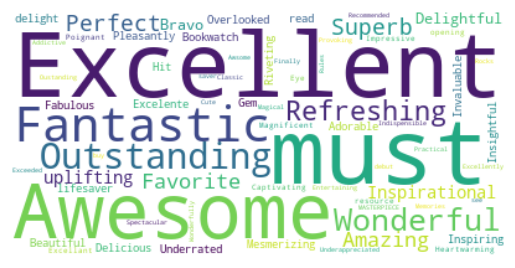

In [191]:
text_positivo_smoothing = " ".join(word[0] for word in palavras_mais_positivas_smoothing)
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text_positivo_smoothing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

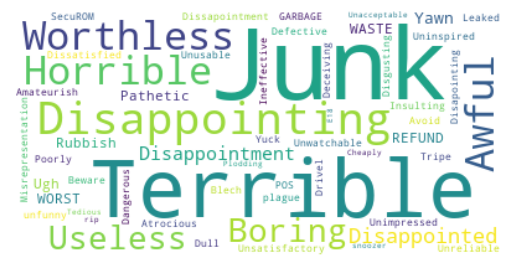

In [192]:
text_negativo_smoothing = " ".join(word[0] for word in palavras_mais_negativas_smoothing)
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text_negativo_smoothing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa